In [2]:
import pandas as pd
import numpy as np
import statistics 

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

###
from pmdarima.arima import auto_arima
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

pd.options.mode.chained_assignment = None 

plt.style.use('ggplot')
%matplotlib inline

# Case 1

Basically: Analyze the data and predict 10 years

In [ ]:
df1 = pd.read_csv('TFP.csv')
df1.year = pd.to_datetime(df1.year,format = '%Y', errors='raise')

In [ ]:
country_grouped = df1.groupby('isocode')
df1.head()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
country_grouped.apply(lambda x: ax.plot(x.year,x.rtfpna, label = x['isocode'].unique()))
plt.title('rtfpna behavior over time')
plt.xlabel('Years')
plt.ylabel('rtfpna')
ax.legend()

TFP = Total factor productivity

It is possible to see that the USA maintained steady growth throughout the historical series, while Mexico saw a fall that almost equaled the level of 1950.

Canada advanced laterally over the years with a steady result between 0.9 and 1.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
country_grouped.apply(lambda x: ax.plot(x.rtfpna.diff().dropna(),label=x.isocode.unique()))
plt.title("First Difference by Country")
ax.legend()

It shows that each country has the data distributed in a different way, the MEX with greater noise (due to its series containing ups and downs), the USA grows constantly (so the data is better behaved) CAN has already presented an average value with some noise.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
df1.rtfpna.hist()
plt.title("histogram")

The histogram shows that most values are close to 1 (similar to a normal distribution)

In [ ]:
def predict_country_values(df):
    
    #country = df1.isocode.unique()[count]
    country = df['isocode'].unique()
    df.drop(['isocode'],axis=1,inplace=True)
    df.apply(lambda x: x.year.year, axis=1)
    df.set_index('year',inplace=True)
    df.index = df.index.year
    
    model = auto_arima(df, start_p =1, start_q=1, max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1, error_action='ignore', suppress_warnigs=True, stepwise=True, n_jobs=-1)
    
    model.fit(df) #Fit the model
    prevision = model.predict(n_periods=11) #Forecasting data
    prevision = pd.DataFrame(prevision, index=prev, columns=['rtfpna']) #Creating a data frame with forecast data
    
    fig, ax = plt.subplots(figsize=(8, 4))
    pd.concat([df,prevision],axis=1).plot(ax=ax)
    ax.legend(["original", "predict"]);
    plt.xlabel("years")
    plt.ylabel("rtfpna")
    plt.title("Preditc " + country)
    print("Akaike Information Criterion of model: "+ str(country) + " " + str("{:.2f}".format(model.aic())))


In [ ]:
prev = np.arange(2011,2022,1) #Range to predict

for i in range(len(df1.isocode.unique())):
    df_actual = df1[df1['isocode'] == df1['isocode'].unique()[i]]
    predict_country_values(df_actual)

The prediction was made using the ARIMA model, where it was used to present the data projection until 2022.

The Akaike Information Criterion metric that defines the quality of a model presented different values for each country.

Where USA obtained the lowest value, due to its data not being close to an average (not stationary).

# Case 2

# Pre processing data

In [6]:
df = pd.read_csv('data_comexstat.csv', sep=',', encoding = "ISO-8859-1")

In [7]:
MILLION = 1000000

In [8]:
df.date = pd.to_datetime(df.date,yearfirst = True, errors='raise')
date_grouped = df.set_index('date')

# 1 - Evoluation of exports

In [ ]:
#Validation product types and exportacion or importation
item_1 = (((date_grouped['product'] == 'soybeans') | (date_grouped['product'] == 'soybean_oil') | (date_grouped['product'] == 'soybean_meal')) & (date_grouped['type'] == 'Export'))
sampled_item_1 = date_grouped.apply(lambda x: x[item_1])

In [ ]:
sampled_item_1.head()

In [ ]:
#Sum of exportancion by month
exportacion = sampled_item_1['tons'].sum(level='date')/MILLION
months = sampled_item_1.index.unique()

In [ ]:
#Plot
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(months, exportacion)
plt.title('Evolution of exports')
plt.xlabel('Month/Year')
plt.ylabel('Tonnes (millions)')

Exports have increased over the years, and due to the distribution in the graph, it is possible to observe a seasonality in production (some months show a great drop in exports).

It is also possible to identify that this is a non-stationary distribution with an upward trend.

# 2 - Most importante products

Most exported product: Soybean.

Product with the highest return in dollars: Soybean.

Represented to be the most important product for Brazilian exports.

In [ ]:
item_2 = ((date_grouped.index.year >= 2014) & (date_grouped['type'] == 'Export'))

In [ ]:
sampled_item_2 = date_grouped.apply(lambda x: x[item_2])

In [ ]:
#Sum values of each product in tonnes and dollars
total = sampled_item_2.set_index('product')
values_to_plot = total['tons'].sum(level='product')/1000
products_by_usd = total['usd'].sum(level='product')/MILLION

In [ ]:
fig, axs = plt.subplots(1, 2, constrained_layout=True,figsize=(15,6))

products = sampled_item_2['product'].unique()

#Plot 1
axs[0].bar(products, values_to_plot)
axs[0].set_title('Export by products in the last 5 years')
axs[0].set_xlabel('Products')
axs[0].set_ylabel('Tonnes (thousands)')

for i in range(len(products)):
    axs[0].text(x = products[i],y = values_to_plot[i], s = int(values_to_plot[i]) )

products = sampled_item_2['product'].unique()

#Plot 2
axs[1].bar(products, products_by_usd, color = 'green')
axs[1].set_title('Value exported in millions')
axs[1].set_xlabel('Products')
axs[1].set_ylabel('Dollars (millions)')

for i in range(len(products)):
    axs[1].text(x = products[i],y = products_by_usd[i], s = int(products_by_usd[i]) )
    
    
fig.suptitle('Most important products', fontsize=16)

plt.show()

# 3 - Routes of corn exportation 

The most importante route is Sea representing 95.6% of total corn exports in last 5 years.

Sea exports represent the largest export channel for all types of products

In [ ]:
#Get last 5 years, exports and corn
item_3 = ((date_grouped.index.year >= 2014) & (date_grouped['type'] == 'Export') & (date_grouped['product'] == 'corn'))
item_3_1 = ((date_grouped.index.year >= 2014) & (date_grouped['type'] == 'Export'))

In [ ]:
#Extract data 
sampled_item_3 = date_grouped.apply(lambda x: x[item_3])
sampled_item_3_1 = date_grouped.apply(lambda x: x[item_3_1])

In [ ]:
routes_corn_export = sampled_item_3.groupby('route').apply(lambda x: x.tons.sum()/1000)

In [ ]:
#Sea representation export 
routes_corn_export['Sea']/routes_corn_export.sum()*100

In [ ]:
#Function do calcule the tonnes exported by product
def route_importance(df_product):
    return df_product.groupby('route').apply(lambda x: x.tons.sum()/1000)

route_export = sampled_item_3_1.groupby('product').apply(route_importance)

In [ ]:
#Show the values os each route of export by product
pd.DataFrame(route_export, columns=['tonnes'])

In [ ]:
routes = sampled_item_3['route'].unique()
routes = np.sort(routes)

fig, ax = plt.subplots()
plt.bar(routes, routes_corn_export)
fig.autofmt_xdate()
plt.title('Corn Tonnes exported in last 5 years')
plt.xlabel('Routes')
plt.ylabel('Tonnes (thousands)')

for i in range(len(routes)):
    plt.text(x = routes[i], y = routes_corn_export[i], s = int(routes_corn_export[i]) )

# 4 - Most important partens with corn and sugar

173 countries are realized importation or exportation with Brazil considering sugar or corn after 2016 (3 yeas ago), was analised the top 10 countries using total of tonnes exported and total usd (dollars) movimented.

It was possible to identify that Iran was the principal destiny of exportation of theses products (23.3 millions of tonnes), and bigest font of usd (4.3 billions).
The second most import country was Egypt considering total of tonnes, but in relation with dollars payed to Brazil is the 4°.

Considering the importation the values are much smaller, the bigest value in tonnes is with Paraguay (4.3 millions of tonnes), and 602 millions of dollars.

In [ ]:
#relationship_between_countries
rbc = pd.DataFrame()

In [ ]:
item_4 = (((date_grouped['product'] == 'corn') | (date_grouped['product'] == 'sugar')) & (date_grouped.index.year >= 2016))
sampled_item_4 = date_grouped.apply(lambda x: x[item_4])

In [ ]:
#Function to calcule the total of tonnes imported and exported per each country
def total_negotiation_export(df_country):
    export_total = df_country[df_country['type'] == 'Export']['tons'].sum()/MILLION
    return export_total

def total_negotiation_import(df_country):
    import_total = df_country[df_country['type'] == 'Import']['tons'].sum()/MILLION
    return import_total

In [ ]:
#Function to calcule the total of USD (dollars) imported and exported per each country
def total_usd_export(df_country):
    export_total_usd = df_country[df_country['type'] == 'Export']['usd'].sum()/1000000000
    return export_total_usd

def total_usd_import(df_country):
    import_total_usd = df_country[df_country['type'] == 'Import']['usd'].sum()/MILLION
    return import_total_usd

In [ ]:
#Apply the functions to sum
rbc['export_total'] = sampled_item_4.groupby('country').apply(total_negotiation_export)
rbc['import_total'] = sampled_item_4.groupby('country').apply(total_negotiation_import)

rbc['export_total_usd'] = sampled_item_4.groupby('country').apply(total_usd_export)
rbc['import_total_usd'] = sampled_item_4.groupby('country').apply(total_usd_import)

In [ ]:
#Get the top 5 countries in import and export by tonnes and usd
top_tons_export = rbc.sort_values('export_total',ascending=False).head(10)
top_tons_import = rbc.sort_values('import_total',ascending=False).head(10)

top_usd_export = rbc.sort_values('export_total_usd',ascending=False).head(10)
top_usd_import = rbc.sort_values('import_total_usd',ascending=False).head(10)

In [ ]:
fig, axs = plt.subplots(2, 1, constrained_layout=True,figsize=(15,10))

#Plot 1
axs[0].bar(top_tons_export.index, top_tons_export['export_total'])
axs[0].set_title('Top 10 countries with more exports (tonnes)')
axs[0].set_xlabel('Countries')
axs[0].set_ylabel('Tonnes (millions)')

for i in range(len(top_tons_export)):
    axs[0].text(x = top_tons_export.index[i], y = top_tons_export['export_total'][i], s = "{:.1f}".format((top_tons_export['export_total'][i])))
    
#Plot 2
axs[1].bar(top_usd_export.index, top_usd_export['export_total_usd'], color = 'green')
axs[1].set_title('Top 10 countries with more exports (dollars)')
axs[1].set_xlabel('Countries')
axs[1].set_ylabel('Dollars (billions)')

for i in range(len(top_tons_export)):
    axs[1].text(x = top_usd_export.index[i], y = top_usd_export['export_total_usd'][i], s = "{:.2f}".format((top_usd_export['export_total_usd'][i])))
    
fig.suptitle('Most important countries', fontsize=16)

plt.show()

In [ ]:
#Total imported (considering dollars)
top_usd_import

In [ ]:
#Total imported (considering tonnes)
top_tons_import

# 5 - most importante UF consediring exportation by product

In almost all of the top 5, with the first in two categories.
The state of PR is present in all the top 5, but its total production considering all UFs is still below MT.

Variance in state of ESTADO, is the bigest showing that of all the products, this export is very concentrated on this platform

In [ ]:
item_5 = ((date_grouped['type'] == 'Export'))

In [ ]:
sampled_item_5 = date_grouped.apply(lambda x: x[item_5])

In [ ]:
#Get the first bigest values in tonnes per each state
def sum_by_UF(df_product):
    return df_product.groupby('state').apply(lambda x: x['tons'].sum()/1000000).sort_values(ascending=False).nlargest(5)

In [ ]:
state_values = sampled_item_5.groupby('product').apply(lambda x: sum_by_UF(x))
index = state_values.index

In [ ]:
#Most Importante States
mis = pd.DataFrame(state_values.values, columns=['tons'], index=index)

In [ ]:
def states_metrics(actual_product):
    actual_product_values = mis[mis.index.get_level_values(0) == str(actual_product)]['tons'].values
    actual_product_states = mis[mis.index.get_level_values(0) == str(actual_product)].index.get_level_values(1)
    return actual_product_states, actual_product_values

In [ ]:
plot_state=[]
for i in range(len(mis.index.get_level_values(0).unique())):
    plot_state.append(states_metrics(mis.index.get_level_values(0).unique()[i]))

In [ ]:
fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(15,10))
count = 0
for i in range(2):
    for j in range(3):
        axs[i,j].bar(plot_state[count][0], plot_state[count][1])
        axs[i,j].set_title(mis.index.get_level_values(0).unique()[count])
        axs[i,j].set_xlabel('States')
        axs[i,j].set_ylabel('Tonnes (millions)')

        for k in range(len(plot_state[count][0])):
            axs[i,j].text(x = plot_state[count][0][k], y = plot_state[count][1][k], s = "{:.1f}".format((plot_state[count][1][k])))
        count+=1
        
fig.suptitle('Most important states by product export', fontsize=16)

#  6 - Predict

Por enquanto só com soja

In [276]:
historical_serie = pd.read_excel('covariates.xlsx')

In [277]:
historical_serie.head(5)

,year,price_soybeans,price_corn,price_soybean_meal,gdp_china,gdp_iran,gpd_netherlands,gdp_spain,gdp_thailand,gdp_world,gdp_egypt,gdp_japan,gdp_vietnam
0,1979,NaN,NaN,NaN,100.000000,100.000000,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,1980,100.000000,100.000000,100.000000,107.900000,81.200000,100.000000,101.200000,104.600000,102.100000,103.400000,103.200000,96.500000
2,1981,98.525508,103.888308,99.805440,113.402900,74.216800,99.500000,100.795200,110.771400,104.039900,105.674800,107.534400,102.097000
3,1982,83.406192,85.986430,86.596956,123.609161,83.939201,98.206500,102.004742,116.753056,104.664139,113.389060,111.083035,110.468954
4,1983,97.851743,108.168059,98.663318,136.958950,95.522811,99.974217,103.738823,123.291227,107.594735,123.480687,114.970941,118.312250


In [278]:
#Anual exportation
item_6 = ((date_grouped['type'] == 'Export') & (date_grouped['product'] == 'soybeans'))
exportations = date_grouped.apply(lambda x: x[item_6])
total_exportation = exportations.groupby(exportations.index.year).apply(lambda x: x['tons'].sum()/MILLION)

In [279]:
#Model for forecast
model = pd.DataFrame(total_exportation)
model.reset_index(inplace=True)
model.columns = ['year','total_exported']

In [280]:
def sjoin(x): return ';'.join(x[x.notnull()].astype(str))

In [281]:
model.set_index('year',inplace=True)

Akaike Information Criterion of model: 67.11


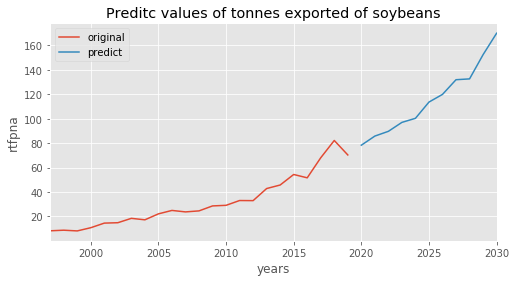

In [282]:
#Use ARIMA to create the model's historical series

prev_range = np.arange(2020,2031,1) #Range to predict
modelo = auto_arima(model, start_p =1, start_q=1, max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1, error_action='ignore', suppress_warnigs=True, stepwise=True, n_jobs=-1)
predict_future = see_the_future(model, prev_range)

In [283]:
def see_the_future(model,prev_range):
    modelo.fit(model) #Fit the model
    prevision = modelo.predict(n_periods=prev_range.size) #Forecasting data
    prevision = pd.DataFrame(prevision, index=prev_range, columns=['total_exported']) #Creating a data frame with forecast data

    fig, ax = plt.subplots(figsize=(8, 4))
    pd.concat([model,prevision],axis=1).plot(ax=ax)
    ax.legend(["original", "predict"]);
    plt.xlabel("years")
    plt.ylabel("rtfpna")
    plt.title("Preditc values of tonnes exported of soybeans")
    print("Akaike Information Criterion of model: "+ str("{:.2f}".format(modelo.aic())))
    return pd.concat([model,prevision],axis=1).groupby(level=0, axis=1).apply(lambda x: x.apply(sjoin, axis=1))

In [284]:
pd.concat([historical_serie, predict_future],axis=1).fillna(method='ffill')

,year,price_soybeans,price_corn,price_soybean_meal,gdp_china,gdp_iran,gpd_netherlands,gdp_spain,gdp_thailand,gdp_world,gdp_egypt,gdp_japan,gdp_vietnam,total_exported
0,1979.0,NaN,NaN,NaN,100.000000,100.000000,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN
1,1980.0,100.000000,100.000000,100.000000,107.900000,81.200000,100.000000,101.200000,104.600000,102.100000,103.400000,103.200000,96.500000,NaN
2,1981.0,98.525508,103.888308,99.805440,113.402900,74.216800,99.500000,100.795200,110.771400,104.039900,105.674800,107.534400,102.097000,NaN
3,1982.0,83.406192,85.986430,86.596956,123.609161,83.939201,98.206500,102.004742,116.753056,104.664139,113.389060,111.083035,110.468954,NaN
4,1983.0,97.851743,108.168059,98.663318,136.958950,95.522811,99.974217,103.738823,123.291227,107.594735,123.480687,114.970941,118.312250,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,2030.0,167.029608,167.140979,183.690870,6102.244946,239.096864,254.300715,275.393270,978.073487,547.625878,848.364039,221.476562,2013.057175,119.88430841785602
2027,2030.0,167.029608,167.140979,183.690870,6102.244946,239.096864,254.300715,275.393270,978.073487,547.625878,848.364039,221.476562,2013.057175,131.90240511776705
2028,2030.0,167.029608,167.140979,183.690870,6102.244946,239.096864,254.300715,275.393270,978.073487,547.625878,848.364039,221.476562,2013.057175,132.57452222067806
2029,2030.0,167.029608,167.140979,183.690870,6102.244946,239.096864,254.300715,275.393270,978.073487,547.625878,848.364039,221.476562,2013.057175,152.4091022035891


In [285]:
predict_future['total_exported'] = pd.to_numeric(predict_future['total_exported'])

In [286]:
prev_pass = np.arange(1979,1997,1) #Range to predict
#see_the_future(predict_future.sort_values('total_exported',ascending=False), prev_pass)

# Linear regression to target values (missing values)

In [287]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [288]:
X = predict_future.sort_values('total_exported',ascending=False).index.values.reshape(-1,1)
y = predict_future.sort_values('total_exported',ascending=False).values

In [289]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y)

In [290]:
reg = LinearRegression(normalize=True).fit(x_scaled, y_scaled)

In [291]:
x_scaled_prev = min_max_scaler.fit_transform(prev_pass.reshape(-1,1))
tager_pass_values = reg.predict(x_scaled_prev)
tager_pass_values = min_max_scaler.inverse_transform(tager_pass_values)

In [302]:
historical_serie['tagert'] = pd.concat([predict_future,pd.DataFrame(data=tager_pass_values, index=prev_pass, columns=['total_exported'])]).sort_index().values

# Regression to target

In [317]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [309]:
X = historical_serie.drop(['tagert'],axis=1)
y = historical_serie['tagert']

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [318]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

C:\Users\stiva\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\stiva\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [320]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)

In [321]:
xg_reg.fit(X_train,y_train)

[02:41:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, colsample_bytree=0.3, max_depth=5, n_estimators=10)

In [322]:
preds = xg_reg.predict(X_test)

In [335]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 314.479355


In [326]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[02:42:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [327]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1058.206767,64.603669,1057.823242,124.726259
1,960.673421,57.600467,968.869568,103.761460
2,872.138163,51.338745,881.335897,93.217980
3,791.770284,45.739959,809.261759,76.348025
4,718.817302,40.736435,738.360433,68.905041


In [328]:
print((cv_results["test-rmse-mean"]).tail(1))

49    173.498233
Name: test-rmse-mean, dtype: float64


[02:43:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


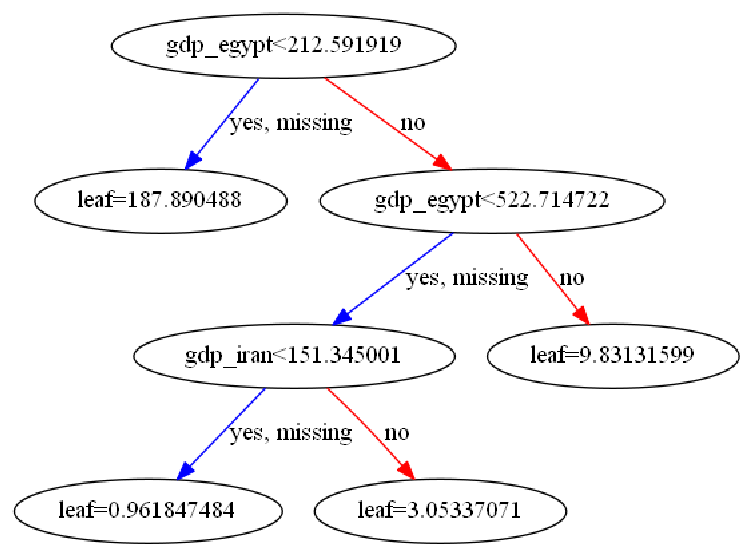

In [331]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [200, 10]
plt.show()

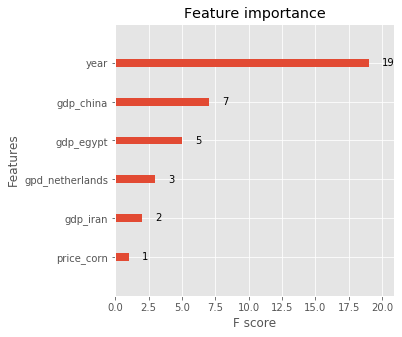

In [333]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [200, 5]
plt.show()

In [338]:
#Fazer regressão da CHina do egito e nerthelasn, com o ano junto.
#Passar tudo isso para um arima classificar o resultado do target